In [61]:
!pip install distance

## Importing libraries...

In [5]:
import pickle

import numpy as np
import pandas as pd
import string
import itertools
from itertools import combinations
from itertools import product
import collections 
from collections import Counter


# models
from sklearn import  svm
from sklearn.tree import DecisionTreeClassifier

# Feature selection
from sklearn import feature_selection
from sklearn import preprocessing,  svm
from sklearn.cluster import AffinityPropagation

# validation
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# vizualization
import matplotlib.pyplot as plt



## Some function to help on data cleaning/processing...

In [4]:
# AUXILIARY FUNCTIONS


## FOR CATEGORIES:
def alpha_views(dataframe, views_ref=None):
    
    df = dataframe.copy()
    cols = df.columns
    column_values = df.values.ravel()
    unique_values =  pd.unique(column_values)
    
    if not views_ref:
        Training = True
        alpha = {}
        for value, label in zip(unique_values, product_gen(string.ascii_uppercase)):
            alpha[value] = label    

        for col in cols:
            df.replace({col: alpha}, inplace = True)

        return df, alpha
    
    # Rename test views according to views_ref
    diff_views = [i for i in list(views_ref) + unique_values.tolist() if i not in views_ref.keys()]
    upd_views = list(views_ref) + diff_views
    alpha = {}
    for value, label in zip(upd_views, product_gen(string.ascii_uppercase)):
            alpha[value] = label    

    for col in cols:
        df.replace({col: alpha}, inplace = True)
    return df

def product_gen(n):
    '''
    Code reference:
    https://stackoverflow.com/questions/6412473/python-assign-letter-of-the-alphabet-to-each-value-in-a-list'''
    
    for r in itertools.count(1):
        for i in itertools.product(n, repeat=r):
            yield "".join(i)


def dict_categ_sequences(sequence, cluster_ref=None, damping=None):
    ''' Return a dictionaire clustering strings listed by levenshtein-distancing. 
    Code reference:
    https://stats.stackexchange.com/questions/123060/clustering-a-long-list-of-strings-words-into-similarity-groups '''
    
    if not cluster_ref:
        Training = True
         ## Affinity clustering by string distance  
        sequence = np.asarray(sequence)
        lev_similarity = -1*np.array([[distance.levenshtein(w1, w2) for w1 in sequence] for w2 in sequence])
        affprop = AffinityPropagation(affinity="precomputed", damping=damping) ## To explore
        affprop.fit(lev_similarity)
       
        ## Run dictionaire d        
        d = {}  
        i = 0
        exemplars = []
        for cluster_id in np.unique(affprop.labels_):
            exemplar = sequence[affprop.cluster_centers_indices_[cluster_id]]
            cluster = np.unique(sequence[np.nonzero(affprop.labels_==cluster_id)])
            exemplars.append(exemplar)        
            key = 'seq_' + str(i)
            d[key] = cluster
            i += 1
                
        ## Assembling output from d
        newdict = {}
        newdict = {i: k for k, v in d.items() for i in v}   
        
        return newdict, exemplars
    
    else:  
        
        # for each sequence, calculate the closest reference
        reference_list = [ cluster_ref[np.argmin([distance.levenshtein(w1, w2) for w1 in cluster_ref])] for w2 in sequence]
        
        # create a dictionaire with reference "keys" and sequence "values"
        dct ={k:[x for id,x in enumerate(sequence) if k == reference_list[id]] for k in reference_list}
        
        # Add missing references to dct and rename keys to seq_():
        new_dct ={}
        for i, cluster in enumerate(cluster_ref):
            if cluster in dct.keys():
                new_dct['seq_'+str(i)] = dct[cluster]
            else:
                new_dct['seq_'+str(i)] = []
                
        # assembling output form new_dct
        newdict = {} 
        newdict = {i: k for k, v in new_dct.items() for i in v}  
        
        return newdict


def new_categ_features(df, cluster_ref=None, Training=True, damping=0.98):       
    '''Generates new features based on the task interpretation'''       
    
    dataframe = df.copy()
    
    if cluster_ref:
        Training = False
    ## Redudancy
    dataframe['not_na'] = dataframe.apply(lambda x: x.count()/6, axis=1)    
    
    ## Diversity
    dataframe['diversity'] = [len(set(v[pd.notna(v)]))/6 for v in dataframe.iloc[:,:-1].values]   
            
    if Training:
        ## Sequence
        dataframe['sequence'] = dataframe[dataframe.columns[:6]].apply(lambda x: ''.join(x.dropna().astype(str)), axis=1)
        sequences = dataframe['sequence'].values
        newdict, keys = dict_categ_sequences(sequences, damping=damping)
        dataframe['seq_categ'] = dataframe.sequence.str.findall('|'.join(newdict.keys())).str[0].map(newdict)        
        
        ## Diversity factor
        dataframe['divesity_factor'] = round(dataframe.diversity * dataframe.not_na,2)        
        ## Drop auxiliars columns
        dataframe = dataframe.drop(['diversity', 'not_na', 'sequence'], axis=1)
                
        return dataframe, keys
        
    else:
        ## Sequence
        dataframe['sequence'] = dataframe[dataframe.columns[:6]].apply(lambda x: ''.join(x.dropna().astype(str)), axis=1)
        sequences = set(dataframe['sequence'].values)
        newdict = dict_categ_sequences(sequences, cluster_ref)
        dataframe['seq_categ'] = dataframe.sequence.str.findall('|'.join(newdict.keys())).str[0].map(newdict)   
        
        ## Diversity factor
        dataframe['divesity_factor'] = round(dataframe.diversity * dataframe.not_na,2)
        ## Drop auxiliars columns
        dataframe = dataframe.drop(['diversity', 'not_na', 'sequence'], axis=1)        
    
        return dataframe

def dummy_new_features(dataframe, valid_cols=None, Training = True):
    '''Convert new created categories into dummy variables'''
    dm_dataframe = dataframe.copy()
    
    if valid_cols is not None:
        Training = False
    
    if Training:        
        dm_dataframe = pd.get_dummies(dataframe.iloc[:,:-1].astype(str), prefix='', prefix_sep='').max(level=0, axis=1)
        dm_dataframe = dm_dataframe.reindex(sorted(dm_dataframe.columns), axis=1)
        dm_dataframe['divesity_factor'] = dataframe['divesity_factor']
        dm_dataframe = dm_dataframe.iloc[:,:-1].multiply(dm_dataframe['divesity_factor'], axis="index")
        dm_dataframe['divesity_factor'] = dataframe.divesity_factor*6
        
        return dm_dataframe, dm_dataframe.iloc[:,:-1].columns
        
    else:
        dm_dataframe = pd.get_dummies(dataframe.iloc[:,:-1].astype(str), prefix='', prefix_sep='').max(level=0, axis=1)
        dm_dataframe = dm_dataframe.reindex(sorted(dm_dataframe.columns), axis=1)        
        test_cols = dm_dataframe.columns        
        # list columns to remove (which are in  test_cols no in training_views values):
        to_drop = []
        for col in test_cols:
            if 'seq_' not in col:
                if col not in valid_cols:
                    to_drop.append(col)
        dm_dataframe = dm_dataframe.drop(to_drop, axis=1)
        # list columns to add (which are not in test_cols but in training_views values):
        to_add = []
        for col in valid_cols:
            if col not in test_cols:
                dm_dataframe[col] = 0
                
        dm_dataframe = dm_dataframe.reindex(sorted(dm_dataframe.columns), axis=1)
        dm_dataframe['divesity_factor'] = dataframe['divesity_factor']
        dm_dataframe = dm_dataframe.iloc[:,:-1].multiply(dm_dataframe['divesity_factor'], axis="index")
        dm_dataframe['divesity_factor'] = dataframe.divesity_factor*6
        
    return dm_dataframe

## FOR SCALARS:
def list_constant_columns(dataframe): 
    '''List columns with no variance'''
    to_drop = []
    result = dataframe.copy()
    for column in dataframe.columns:
        
        if dataframe[column].std() == 0:
            to_drop.append(column)
    return to_drop

def list_lcorr_columns(dataframe, threshold=0.1):
    '''List columns with 'Label-Correlation' lower than threshold'''
    to_drop = []
    for col in dataframe.columns:
        corr = dataframe[col].corr(dataframe['labels'])
        if abs(corr) < threshold:
            to_drop.append(col)
    return to_drop


def replace_nan_norm(dataframe, norm_list=None, Training=True):
    '''Replace Nan values and normalize according to the training set'''
    df = dataframe.copy()

    if norm_list:
        Training = False
        
    if Training:
        norm_list = []
        for col in df.iloc[:,:-1].columns:
            mean = np.nanmean(df[col]) 
            std = np.std(df[col])
            df[col] = df[col].fillna(mean)
            df[col] =(df[col]-mean )/std            
            norm_list.append([mean, std])
            
        return df, norm_list
        
    else:
        assert dataframe.shape[1] == len(norm_list), 'Different sizes: df={} meanlist={} size board.'.format(dataframe.shape[1], len(mean_list))
        for id, col in enumerate(df.columns):
            df[col] = df[col].fillna(norm_list[id][0])
            df[col] = (df[col]-norm_list[id][0] )/norm_list[id][1]
            
        return df

## Importing the datasets...

In [72]:
test_data = pickle.load(open("C:/Users/b_tib/coding/Msc/oLINGI2262/Inginious_task_5/test.pickle", "rb"))
(train_data_1, train_labels_1) = pickle.load(open("C:/Users/b_tib/coding/Msc/oLINGI2262/Inginious_task_5/train1.pickle", "rb"))
(train_data_2, train_labels_2) = pickle.load(open("C:/Users/b_tib/coding/Msc/oLINGI2262/Inginious_task_5/train2.pickle", "rb"))

## Splitting categorical and scalar values ...

In [73]:
# MERGING 1 & 2:
train_data = train_data_1.append(train_data_2)
train_labels =np.concatenate((train_labels_1, train_labels_2), axis=None)

# SEPARTING SCALAR:
train_data_scalar = train_data.iloc[:,:1306624]
test_data_scalar = test_data.iloc[:,:1306624] # Test (no labels)
#train_data_scalar['labels'] = train_labels

## Categories
train_data_categ_raw = train_data.iloc[:,1306624:]
test_data_categ_raw= test_data.iloc[:,1306624:] # Test

## Processing
### 1) Divide dataframe into subsets by:
#### - Damping categorical according to damping coeficients
#### - Renmoving columns with low target-correlation according to threshold
### 2) Concatenate damping/thresholds subsets into dct_subsets:
#### - Store possible pairwises into a dictionaire
#### - For each pairwise, run most importante features (run in google colab)
### 3) Run the most relevant features for each dct_subsets and stored in dct_features:

In [ ]:


# THIS STEP WAS COMPUTED IN GOOGLE COLAB
# THE MOST IMPORTA COLUMNS NAMES ARE STORED IN "dct_features".HOWEVER, THERE IS MORE...
# THE FUNCTION REPLAN NAN AND NORMILIZE EXTEND TRAIN-SET KNOWNLEDGE TO TEST-SET BEFORE PREDICTION 

# PROCESSING CATEGORIES
dampings = [0.9] #  0.95, 0.98
dct_categ = {}
for damping in dampings:
  try:
      ## Convert views into alphabethic variable for distancing
      train_data_angles, training_views = alpha_views(train_data_angles) # for colab: remove "-" 
      test_data_angles = alpha_views(test_data_angles, training_views) # for colab: remove "-" 

      ## Applying edit-distancing and clustering using AffinityPropagation
      nf_train_data_angles, keys = new_categ_features(train_data_angles, damping=damping) 
      nf_test_data_angles = new_categ_features(test_data_angles, keys)

      ## Converting new categories in dummy variables
      train_data_categ, valid_columns = dummy_new_features(nf_train_data_angles) 
      test_data_categ = dummy_new_features(nf_test_data_angles, valid_cols=valid_columns)

      dct_categ[damping] = [train_data_categ, test_data_categ]
      
  except Exception:
      pass  # or you could use 'continue'

# PROCESSING SCALARS

thresholds = [0.1] #0.2, 0.3
dct_scalar = {}
for threshold in thresholds:
  try:
      ## listing columns to drop based on low correlation threshold based on train-set:
      drop_constants = list_constant_columns(train_data_vector) # for colab: remove "-" 
      drop_low_corr = list_lcorr_columns(train_data_vector, threshold = threshold) # for colab: remove "-"  

      ## Dropping columns to drop based on low correlation threshold:
      dp_train_data_vector = train_data_vector.drop(drop_constants, axis=1) # for colab: remove "-" 
      dp_train_data_vector = dp_train_data_vector.drop(drop_low_corr, axis=1)

      dp_test_data_vector = test_data_vector.drop(drop_constants, axis=1) # for colab: remove "-" 
      dp_test_data_vector = dp_test_data_vector.drop(drop_low_corr, axis=1)

      ## Replacing Nan values and normalizing columns based on train-set:
      train_data_scalar, norm_list = replace_nan_norm(dp_train_data_vector)
      test_data_scalar = replace_nan_norm(dp_test_data_vector, norm_list=norm_list)

      dct_scalar[threshold] = [train_data_scalar, test_data_scalar]

  except Exception:
      pass  # or you could use 'continue'


# Concatenating train and test SUBSETS
dct_subsets = {}
for k_categ, v_categ in dct_categ.items():
  for k_scalar, v_scalar in dct_scalar.items():
    # merger keys
    k_db = str(k_categ) + '_' + str(k_scalar)

    # merge values
    dct_subsets[k_db] = [pd.concat([v_categ[0], v_scalar[0]], axis=1), pd.concat([v_categ[1], v_scalar[1]], axis=1)]


# Passing dataframe through Decision tree importance and getting most significant features for each. 
dct_features = {}

for k, v in dct_subsets.items():

  train = v[0]

  # DECISION TREE Best Features
  x_train = train.iloc[:,:-1]
  Y_train = train.iloc[:,-1:]
  clf = DecisionTreeClassifier(random_state=0)
  clf = clf.fit(x_train, Y_train)
  dct= dict(zip(x_train.columns, clf.feature_importances_))
  dct = {k: v for k, v in sorted(dct.items(), key=lambda item: item[1], reverse=True)}
  features = {x:y for x,y in dct.items() if y!=0}
  if features not in dct_features.values():
    dct_features[k] = features

## Feature Selection
### - Apply damping, threshold and relevant features for a clean experiemntal database.
### - Using raw (train/test) data, remember to replace Nan by the mean only (standardization during the cross validations).
### - *In the raw test data, the Nan replacements is according to train data mean. 


In [74]:
dct_databases = {}
i=0


for k, v in dct_features.items():
    
    damping = float(k.split('_')[0])
    threshold = float(k.split('_')[1])
    
    # PROCESSING CATEGORIES

    ## Convert views into alphabethic variable for distancing
    train_data_angles, training_views = alpha_views(train_data_categ_raw) 
    test_data_angles = alpha_views(test_data_categ_raw, training_views) 

    ## Applying edit-distancing and clustering using AffinityPropagation
    nf_train_data_angles, keys = new_categ_features(train_data_angles, damping=damping) # v.split('_')[0]
    nf_test_data_angles = new_categ_features(test_data_angles, keys)

    ## Converting new categories in dummy variables
    train_data_categ, valid_columns = dummy_new_features(nf_train_data_angles) 
    test_data_categ = dummy_new_features(nf_test_data_angles, valid_cols=valid_columns)
    
    # MERGING CATEGORIES & SCALARS    
    x_train = pd.concat([train_data_categ, train_data], axis=1) # merges into train data because the scalar will be selected autommaticalli by the features
    x_test = pd.concat([test_data_categ, test_data], axis=1) # merges into train data because the scalar will be selected autommaticalli by the features
    

    # FEATURE SELECTION ON RAW DATA 
    x_train = x_train[v]
    x_test = x_test[v]
    

    # SELECT FEATURES PROCESSING: Remove Nan & ""NOT"" Normalize    
    x_train, mean_list = replace_nan(x_train)
    x_test = replace_nan(x_test, mean_list=mean_list)
    Y_train = train_labels 

    
    # check all columns are equal between x_train & x_test
    assert x_train.columns.all() == x_test.columns.all(), 'train={} and test={} columsn are different.'.format(x_test.shape[1], x_test.shape[1])
    
    dct_databases[i] = [damping, threshold, x_train, Y_train, x_test]
    i += 1
    
    
    print('x_train:',x_train.shape)
    print('\tThe number of missing Values:',x_train.isna().sum().sum())
    print('\tThe average number of missing Values for each attribute:',np.mean(x_train.isnull().sum()))
    print('\tThe standard deviation of the average number of missing Values for each attribute:',np.std(x_train.isnull().sum()))

    print('x_test:',x_test.shape)
    print('\tThe number of missing Values:',x_test.isna().sum().sum())
    print('\tThe average number of missing Values for each attribute:',np.mean(x_test.isnull().sum()))
    print('\tThe standard deviation of the average number of missing Values for each attribute:',np.std(x_test.isnull().sum()))


0.8 0.1
C:\Users\b_tib\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "
x_train: (309, 20)
	The number of missing Values: 0
	The average number of missing Values for each attribute: 0.0
	The standard deviation of the average number of missing Values for each attribute: 0.0
x_test: (103, 20)
	The number of missing Values: 0
	The average number of missing Values for each attribute: 0.0
	The standard deviation of the average number of missing Values for each attribute: 0.0
0.8 0.2
C:\Users\b_tib\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to 

In [75]:
dct_features={'0.8_0.1': {35263: 0.026188480092357164,
  45658: 0.02973821520382632,
  162020: 0.12808588780188707,
  167957: 0.01207678220475255,
  188664: 0.01150169733785957,
  264555: 0.046907453111410126,
  339787: 0.0808855475498934,
  362546: 0.0621665799892215,
  404039: 0.021469835030671194,
  406583: 0.060227069696428284,
  501756: 0.04925181091133322,
  594089: 0.06937725947411037,
  761990: 0.14351154614285724,
  846307: 0.012816177033614953,
  852873: 0.038585813643910685,
  903269: 0.05513940665794529,
  1001789: 0.013711827414546322,
  1080786: 0.03105458281222084,
  1118650: 0.09695250028708043,
  1294587: 0.010351527604073612},
 '0.8_0.2': {4117: 0.04968733249955333,
  6179: 0.030611798261165758,
  10474: 0.03943439087266137,
  16474: 0.017148284437409924,
  31899: 0.013479400610422673,
  137221: 0.06686668222761828,
  256125: 0.10306616214468638,
  437665: 0.04622019308329932,
  594186: 0.03505279188681011,
  633092: 0.07368754094455365,
  659771: 0.02628959391510759,
  678530: 0.02555392890257758,
  679957: 0.011830317261798414,
  760039: 0.013693359350270556,
  761990: 0.14351154614285724,
  803407: 0.03312488833303555,
  809822: 0.026151227631343876,
  938706: 0.018402715740575306,
  1164254: 0.05074450978677787,
  1235905: 0.05280518609369591,
  1290671: 0.009201357870287653,
  1292566: 0.11343679200349172},
 '0.8_0.3': {1028116: 0.006395981466978193,
  1036559: 0.03875671055104585,
  1073172: 0.05578637537163887,
  1118502: 0.013075613815671938,
  1120458: 0.025926432918871443,
  120689: 0.023536104868209475,
  1209066: 0.024646494295413355,
  1210206: 0.026151227631343876,
  1212254: 0.013916497942353837,
  1292684: 0.025303734143291044,
  1294888: 0.006901018402715741,
  1294941: 0.053707250405481625,
  251297: 0.004495319875560348,
  298401: 0.012554679477118974,
  339988: 0.02954658249459037,
  374177: 0.012735322347293264,
  393373: 0.1089777620343429,
  397374: 0.0230936040666043,
  437665: 0.03342011208408998,
  43927: 0.043662839292922306,
  464289: 0.015104705974537223,
  535969: 0.014492353029623685,
  59263: 0.027834107557620155,
  639081: 0.01237785300561019,
  641101: 0.031027314350447168,
  676121: 0.0167789467046422,
  721707: 0.006901018402715741,
  761990: 0.14954210053237535,
  807267: 0.006901018402715741,
  855052: 0.009201357870287653,
  894893: 0.006591278611008029,
  899769: 0.019717195436330687,
  899778: 0.013802036805431482,
  899956: 0.009201357870287653,
  929185: 0.03331456544702834,
  984907: 0.03542176864351336,
  'D': 0.009201357870287653},
 '0.95_0.1': {14695: 0.013711827414546318,
  45658: 0.029738215203826312,
  97348: 0.011501697337859568,
  108028: 0.0492518109113332,
  162020: 0.12808588780188704,
  232378: 0.01035152760407361,
  264555: 0.04690745311141012,
  315124: 0.012076782204752546,
  339787: 0.08088554754989338,
  362546: 0.06216657998922149,
  406583: 0.06022706969642827,
  594089: 0.06937725947411036,
  602919: 0.031054582812220833,
  620427: 0.01281617703361495,
  696765: 0.021469835030671187,
  761990: 0.14351154614285722,
  846810: 0.02618848009235716,
  903269: 0.05513940665794528,
  1118650: 0.0969525002870804,
  1167222: 0.03858581364391068},
 '0.95_0.2': {4117: 0.04968733249955332,
  6179: 0.030611798261165755,
  67058: 0.013479400610422671,
  69874: 0.018402715740575306,
  137221: 0.06686668222761828,
  159934: 0.013693359350270554,
  256125: 0.10306616214468636,
  291201: 0.009201357870287653,
  303244: 0.03312488833303554,
  437665: 0.04622019308329931,
  633092: 0.07368754094455364,
  659771: 0.026289593915107587,
  678530: 0.025553928902577575,
  761990: 0.14351154614285722,
  809822: 0.026151227631343872,
  909389: 0.011830317261798414,
  1028660: 0.03943439087266137,
  1085751: 0.03505279188681011,
  1164254: 0.05074450978677787,
  1235905: 0.0528051860936959,
  1254376: 0.01714828443740992,
  1292566: 0.1134367920034917},
 '0.95_0.3': {1036559: 0.05183232436671778,
  1067060: 0.009201357870287653,
  1073172: 0.05578637537163887,
  1089398: 0.024646494295413355,
  120689: 0.023536104868209475,
  1209066: 0.023290937109165626,
  1212254: 0.0248438806336973,
  1292718: 0.012651867071645525,
  1294941: 0.053707250405481625,
  339988: 0.02954658249459037,
  348374: 0.009201357870287653,
  352540: 0.006276541000925606,
  374177: 0.01237785300561019,
  393373: 0.11633884833057301,
  397374: 0.013356809811707875,
  437665: 0.03342011208408998,
  43927: 0.057464876098353795,
  464289: 0.01391649794235383,
  535969: 0.015104705974537223,
  59263: 0.027834107557620155,
  61472: 0.019717195436330687,
  639081: 0.021756037347406627,
  641101: 0.031027314350447168,
  722976: 0.019154654663308505,
  761990: 0.14351154614285724,
  805545: 0.009201357870287653,
  854933: 0.009201357870287653,
  899578: 0.012735322347293264,
  940340: 0.020662698375382815,
  944922: 0.026151227631343876,
  984907: 0.03542176864351336,
  'A': 0.019717195436330687,
  'seq_23': 0.01291989223638457,
  'seq_34': 0.004487547485919025},
 '0.98_0.1': {9541: 0.01035152760407361,
  45658: 0.029738215203826315,
  84904: 0.012816177033614951,
  97268: 0.026188480092357164,
  108028: 0.04925181091133321,
  162020: 0.12808588780188707,
  264555: 0.04690745311141012,
  339787: 0.08088554754989338,
  362546: 0.062166579989221496,
  408215: 0.06022706969642828,
  594089: 0.06937725947411036,
  651227: 0.031054582812220836,
  692572: 0.011501697337859568,
  761990: 0.14351154614285724,
  886644: 0.03858581364391068,
  903269: 0.055139406657945284,
  1032795: 0.02146983503067119,
  1055332: 0.012076782204752548,
  1118650: 0.09695250028708041,
  1245471: 0.01371182741454632},
 '0.98_0.2': {4117: 0.04968733249955332,
  6179: 0.030611798261165755,
  20346: 0.013693359350270554,
  77586: 0.013479400610422671,
  137221: 0.06686668222761828,
  256125: 0.10306616214468636,
  279373: 0.03505279188681011,
  437665: 0.04622019308329931,
  633092: 0.08551785820635206,
  676418: 0.025553928902577575,
  761990: 0.14351154614285722,
  803141: 0.03312488833303554,
  940479: 0.018402715740575306,
  944887: 0.009201357870287653,
  997935: 0.01714828443740992,
  1081371: 0.026151227631343872,
  1164254: 0.05074450978677787,
  1235905: 0.0528051860936959,
  1253250: 0.026289593915107587,
  1290853: 0.03943439087266137,
  1292566: 0.1134367920034917},
 '0.98_0.3': {43927: 0.057464876098353795,
  59263: 0.027834107557620155,
  120689: 0.006901018402715741,
  251297: 0.004495319875560348,
  295057: 0.023536104868209475,
  311283: 0.009201357870287653,
  339988: 0.02954658249459037,
  374177: 0.012735322347293264,
  393373: 0.09977640416405523,
  397374: 0.020662698375382815,
  403716: 0.009201357870287653,
  437665: 0.03342011208408998,
  464289: 0.015104705974537223,
  535969: 0.014492353029623685,
  637033: 0.012554679477118974,
  641101: 0.031027314350447168,
  676121: 0.0167789467046422,
  761990: 0.14954210053237535,
  854933: 0.009201357870287653,
  855052: 0.006901018402715741,
  894893: 0.006395981466978193,
  897721: 0.019717195436330687,
  899578: 0.01237785300561019,
  899769: 0.013075613815671938,
  929185: 0.0230936040666043,
  945094: 0.009201357870287653,
  984907: 0.042322787046229104,
  1028116: 0.006209237482540754,
  1036559: 0.03875671055104585,
  1073172: 0.05578637537163887,
  1120458: 0.026308474047338718,
  1167198: 0.026151227631343876,
  1209066: 0.0315475126981291,
  1212254: 0.026568365013999364,
  1292632: 0.009201357870287653,
  1292660: 0.009201357870287653,
  1294941: 0.053707250405481625},
 '0.9_0.1': {6325: 0.021469835030671187,
  24306: 0.012076782204752546,
  45658: 0.029738215203826312,
  108028: 0.0492518109113332,
  162020: 0.12808588780188704,
  264555: 0.04690745311141012,
  319613: 0.03858581364391068,
  332192: 0.01035152760407361,
  339787: 0.08088554754989338,
  362546: 0.06216657998922149,
  408215: 0.06022706969642827,
  594089: 0.06937725947411036,
  630860: 0.013711827414546318,
  753672: 0.031054582812220833,
  761990: 0.14351154614285722,
  817381: 0.02618848009235716,
  903269: 0.05513940665794528,
  1034438: 0.011501697337859568,
  1118650: 0.0969525002870804,
  1305066: 0.01281617703361495},
 '0.9_0.2': {4117: 0.04968733249955333,
  6179: 0.030611798261165758,
  16474: 0.017148284437409924,
  31828: 0.013693359350270556,
  137221: 0.06686668222761828,
  159934: 0.013479400610422673,
  256125: 0.10306616214468638,
  274511: 0.02628959391510759,
  437665: 0.04622019308329932,
  594186: 0.03505279188681011,
  633092: 0.07368754094455365,
  678530: 0.02555392890257758,
  761990: 0.14351154614285724,
  782309: 0.011830317261798414,
  803153: 0.03312488833303555,
  809822: 0.026151227631343876,
  813013: 0.018402715740575306,
  1028781: 0.03943439087266137,
  1075746: 0.009201357870287653,
  1164254: 0.05074450978677787,
  1235905: 0.05280518609369591,
  1292566: 0.11343679200349172},
 '0.9_0.3': {1028116: 0.006209237482540754,
  1036559: 0.03875671055104585,
  10382: 0.019717195436330687,
  1073172: 0.05578637537163887,
  1073461: 0.009201357870287653,
  1089398: 0.024646494295413355,
  1120458: 0.0060305543895181465,
  1167198: 0.031027314350447168,
  1210206: 0.009201357870287653,
  1212254: 0.02890674277996871,
  1292746: 0.009201357870287653,
  1294941: 0.053707250405481625,
  295057: 0.026151227631343876,
  298401: 0.012735322347293264,
  339988: 0.02954658249459037,
  365985: 0.013356809811707875,
  374177: 0.012554679477118974,
  393373: 0.09977640416405523,
  397374: 0.012651867071645525,
  437665: 0.03342011208408998,
  43927: 0.043662839292922306,
  456097: 0.013075613815671938,
  464289: 0.01391649794235383,
  535969: 0.014492353029623685,
  589828: 0.016562444166517778,
  59263: 0.027834107557620155,
  61472: 0.006901018402715741,
  637033: 0.01237785300561019,
  641101: 0.023536104868209475,
  676525: 0.006901018402715741,
  721707: 0.006901018402715741,
  722976: 0.019154654663308505,
  761990: 0.14990752760983542,
  884946: 0.019717195436330687,
  894893: 0.006591278611008029,
  940340: 0.020662698375382815,
  942023: 0.009201357870287653,
  945189: 0.006901018402715741,
  984907: 0.03542176864351336,
  985396: 0.009201357870287653,
  'seq_46': 0.004495319875560348}}




In [78]:
# selecting better data-set: 9
k = 9
damping = dct_databases[k][0]
threshold = dct_databases[k][1]
x_train = dct_databases[k][2]
Y_train = dct_databases[k][3]
x_test = dct_databases[k][4]


# From here...

1) Create "First" Bag Class (Decision tree) and test Single CV   

2) Create "Second" Bag Class (SVC) and test Single CV <----

3) Create Double (Model comparisson) Nested-CV

4) Convert Single/Double Nested-CV into class

5) Create a classifier inherates bag classes:  self.super()/decide prediction by votes

6) Store classes as libraries

## Models

### 1) Bagging Trees

In [43]:
class BaggingTrees:
    """Expand the subset of features in regards each node split for
    a more flexible tunning.

    Parameters
    ----------
    X_t : np.array
        Training set features.
    Y_t : np.array
        Training set labels.
    X_v : np.array
        Validation set features.
    p : list
            0: epochs
            1: n_trees
            2: criterion
            3: min_samples_leaf
            4: max_depth
            5: min_samples_splits
            6: max_leaf_nodes
    Output
    -------
    y_pred:      predictions on validation set X_v (array)
    unan_rates:  rate of majority votes (array)
    acc:         accuracy on training set Y_t (integer)
    f1:          f1 score on training set Y_t (integer)
    """
        
    def __init__(self, p):

        # store parameters   
        self.epochs = p[0]; self.n_trees = p[1]
        self.criterion = p[2]; self.min_samples_leaf = p[3]
        self.max_depth = p[4]; self.min_samples_splits = p[5]
        self.max_leaf_nodes = p[6]    
        
        
    def fit(self, X_t, Y_t):
        
        if isinstance(X_t,np.ndarray):
            X_t = pd.DataFrame(X_t)
        elif not isinstance(X_t,pd.core.frame.DataFrame):
            raise Exception('Wrong type for X_t. Expected np.ndarray or pd.DataFrame')

        if isinstance(Y_t,np.ndarray):
            Y_t = pd.DataFrame(Y_t)
        elif not isinstance(X_v,pd.core.frame.DataFrame):
            raise Exception('Wrong type for Y_t. Expected np.ndarray or pd.DataFrame')

        self.X_t_df = X_t.copy(); self.Y_t_df = Y_t.copy()

        X_t['label'] = Y_t
        train_df = X_t
        for i in range(self.epochs):
            self.bag = []
            for run in np.arange(self.n_trees):            
                # resampling the dataframe (number of distinct, number of distinct)
                train_df_bs = train_df.iloc[np.random.randint(len(train_df), size=len(train_df))]
                X_train = train_df_bs.iloc[:,:-1]
                Y_train = train_df_bs.iloc[:,-1:]
                # Storing each trained tree
                wl = DecisionTreeClassifier(criterion=self.criterion
                                        , min_samples_leaf=self.min_samples_leaf
                                        , max_depth=self.max_depth
                                        , min_samples_split=self.min_samples_splits
                                        , max_leaf_nodes=self.max_leaf_nodes).fit(X_train,Y_train) 
                                        #, random_state=run  
                # add tree into bag
                self.bag.append(wl)

        ## Score on Training set
        t_predictions = []
        for i in range(self.n_trees):        
            tree_t_prediction = self.bag[i].predict(self.X_t_df) # predict validation and training sets   
            t_predictions.append(tree_t_prediction) # Append predictions
        
        # Convert predictions lists into np.array to transpose them and obtain "n_tree" predictions per line
        t_predictions_T = np.array(t_predictions).T

        t_final_predictions = []
        # for each entry "m" of X_t_df(m x features)
        for line in t_predictions_T:
            # countabilize the "n_tree" votes in v_predictions_T (m x n_tree)
            most_common = Counter(line).most_common(1)[0][0]
            t_final_predictions.append(most_common) 

        # accuracies values
        self.acc = accuracy_score(self.Y_t_df, t_final_predictions)
        self.f1 = f1_score(self.Y_t_df, t_final_predictions, average='macro')
        self.bcr = balanced_accuracy_score(self.Y_t_df, t_final_predictions)
        self.auc = roc_auc_score(self.Y_t_df, t_final_predictions, average='macro')
        return 
            
    def predict(self, X_v): 

        if isinstance(X_v,np.ndarray):
            X_v = pd.DataFrame(X_v)
        elif not isinstance(X_v,pd.core.frame.DataFrame):
            raise Exception('Wrong type for X_v. Expected np.ndarray or pd.DataFrame')

        self.X_v_df = X_v.copy()
        ## Prediction on Validation set
        v_predictions = []
        # each tree will make a prediction about test_df
        for i in range(self.n_trees):
            tree_v_prediction = self.bag[i].predict(self.X_v_df) # predict validation and training sets
            v_predictions.append(tree_v_prediction) # Append predictions
        # Convert predictions lists into np.array to transpose them and obtain "n_tree" predictions per line
        v_predictions_T = np.array(v_predictions).T
        
        self.prediction = []   
        self.votes = [] 
        # for each entry "n" of X_v_df(n x features)
        for line in v_predictions_T:
            # countabilize the "n_tree" votes in v_predictions_T (n x n_tree) 
            most_common = Counter(line).most_common(1)[0][0]
            unanimity_rate = Counter(line)[most_common] / len(line)
            # get prediction and unanimity rate
            self.prediction.append(most_common)
            self.votes.append(unanimity_rate)
        return self.prediction
        



### 2) SVC

In [10]:
class BaggingSVC:
    """Expand the subset of features in regards each node split for
    a more flexible tunning.

    Parameters
    ----------
    X_t : np.array
        Training set features.
    Y_t : np.array
        Training set labels.
    X_v : np.array
        Validation set features.
    p : list
            0: epochs
            1: n_svc
            2: C
            3: kernel
            4: gamma
            5: coef0
            6: degree
            7: tol

    Output
    -------
    y_pred:      predictions on validation set X_v (array)
    unan_rates:  rate of majority votes (array)
    acc:         accuracy on training set Y_t (integer)
    f1:          f1 score on training set Y_t (integer)
    """
        
    pass

## Validation

In [11]:
###########################################################################
# * FINISH SINGLE-MODEL NESTED AND THEM ADD THE DOUBLE-MODEL NESTE
# ** AFTER MODIFIED THE BAGGIN INTO CLASS, MAKE CV-NESTED GENERICAL 
##########################################################################

def nested_single_cv(x_t, y_t, k_ext, k_int, hp_set):
    """   
    Help set a hyper-parameters list for a given model before makes 
    its comparison with others hyper-parameterized models.
        
    Input: 
        - x_t: features train (numpy.arrays)
        - y_t: labels train (numpy.arrays)
        - K_ext: number of external folds (integer) 
        - K_int: number of internal folds (integer)
        - model: learning algorithm function (function or class)
        - hp_set: list of parameters of the learning algorithm (array)

    Output: 
        - train_acc mean
        - train_acc std
        - train_f1 mean
        - train_f1 std        
        - train_bcr mean
        - train_bcr std
        - test_acc mean
        - test_acc std
        - test_f1 mean
        - test_f1 std
        - test_bcr mean
        - test_bcr std
    """
    
    
    results_frame = pd.DataFrame(columns =['hp_hat' 
                                        , 't_bcr_mean'
                                        , 'v_bcr_mean'
                                        , 'v_bcr_std'])
    
    # frame pointer
    i = 0   
    # partionate "training rows" into "K_ext" sets   
    K_ext_folds = KFold(n_splits = k_ext, shuffle=False).split(x_t)  # (markers t_i, v_i)
    for t_ext_fold, v_ext_fold in K_ext_folds:
        # sectioning "train set" between "S_k" into "ext_fold" sets            
        x_S_k = x_t[t_ext_fold] # training x
        y_S_k = y_t[t_ext_fold] # training y            
        x_ext_fold = x_t[v_ext_fold] # test x 
        y_ext_fold = y_t[v_ext_fold] # test y
        
        
        # get hp_hat in the inner loop
        hp_hat, hp_mean = None, 0
        hp_dic = {}
        for idx, hp in enumerate(hp_set):  
            hp_dic[idx]=[]
            # partionate "S_k training rows" into "K_int" sets
            K_int_folds = KFold(n_splits = k_int, shuffle=False).split(x_S_k)   
            for t_int_fold, v_int_fold in K_int_folds:
                # sectioning "S_k" between "Ss_k" into "int_fold" sets                
                x_Ss_k = x_S_k[t_int_fold] # training x
                y_Ss_k = y_S_k[t_int_fold] # training y  
                x_int_fold = x_S_k[v_int_fold] # test x
                y_int_fold = y_S_k[v_int_fold] # test y
                
                # must scaler after partition, for specific a training normalization
                min_max_scaler = MinMaxScaler(feature_range=(0, 1))
                X_t = min_max_scaler.fit_transform(x_Ss_k)
                X_v = min_max_scaler.fit_transform(x_int_fold)
                Y_t = y_Ss_k
                Y_v = y_int_fold
                
                # Loading models
                m = bagging_trees(X_t, Y_t, X_v, hp)
                # prediction
                Y_v_predicted = m[0]             
                # validation
                v_bcr = balanced_accuracy_score(Y_v, Y_v_predicted)
                # append all 
                hp_dic[idx].append(v_bcr)
            
        # avg all hp predictions scores and define the higher to hp_hat
        ixd_max= max([(k,np.mean(v)) for k,v in hp_dic.items()],key=lambda item:item[1])[0]
        hp_hat = hp_set[ixd_max]  
        
        # must scaler after partition, for specific a training normalization
        min_max_scaler = MinMaxScaler(feature_range=(0, 1))
        X_t = min_max_scaler.fit_transform(x_S_k)
        X_v = min_max_scaler.fit_transform(x_ext_fold)
        Y_t = y_S_k
        Y_v = y_ext_fold

        #  Loading models                       
        m = bagging_trees(X_t, Y_t, X_v, hp_hat) # v_final_predictions, unanimity_rates, acc, bcr, f1

        # validation
        Y_v_predicted = m[0]

        # training
        t_acc = m[2]
        t_bcr = m[3]
        t_f1 = m[4] 
        t_auc = m[5] 
        # validation
        v_acc = accuracy_score(Y_v, Y_v_predicted)
        v_bcr = balanced_accuracy_score(Y_v, Y_v_predicted)
        v_f1 = f1_score(Y_v, Y_v_predicted, average='macro')
        v_auc = roc_auc_score(Y_v, Y_v_predicted, average='macro')
    
        results_frame.loc[i] = [hp_hat 
                                , t_bcr_mean
                                , v_bcr_mean
                                , v_bcr_std]
        i += 1
    
        
    return results_frame

def nested_single_cv2(x_t, y_t, L, k_ext, k_int, hp_set):
    """   
    Help set a hyper-parameters list for a given model before makes 
    its comparison with others hyper-parameterized models.
        
    Input: 
        - x_t: features train (numpy.arrays)
        - y_t: labels train (numpy.arrays)
        - K_ext: number of external folds (integer) 
        - K_int: number of internal folds (integer)
        - model: learning algorithm function (function or class)
        - hp_set: list of parameters of the learning algorithm (array)

    Output: 
        - train_acc mean
        - train_acc std
        - train_f1 mean
        - train_f1 std        
        - train_bcr mean
        - train_bcr std
        - test_acc mean
        - test_acc std
        - test_f1 mean
        - test_f1 std
        - test_bcr mean
        - test_bcr std
    """
    
    
    results_frame = pd.DataFrame(columns =['hp_hat' 
                                        , 't_acc'
                                        , 'v_acc'
                                        , 't_bcr'
                                        , 'v_bcr'
                                        , 't_f1'
                                        , 'v_f1'
                                        , 't_auc'
                                        , 'v_auc'])
    
    # frame pointer
    i = 0
    # experiemental 3 metrics each one with mean & std 
    outer = np.empty((0,6), float)
    # partionate "training rows" into "K_ext" sets   
    K_ext_folds = KFold(n_splits = k_ext, shuffle=False).split(x_t)  # (markers t_i, v_i)
    for t_ext_fold, v_ext_fold in K_ext_folds:
        # sectioning "train set" between "S_k" into "ext_fold" sets            
        x_S_k = x_t[t_ext_fold] # training x
        y_S_k = y_t[t_ext_fold] # training y            
        x_ext_fold = x_t[v_ext_fold] # test x 
        y_ext_fold = y_t[v_ext_fold] # test y
        
        
        # get hp_hat in the inner loop
        hp_hat, hp_mean = None, 0
        hp_dic = {}
        for idx, hp in enumerate(hp_set):  
            hp_dic[idx]=[]
            # partionate "S_k training rows" into "K_int" sets
            K_int_folds = KFold(n_splits = k_int, shuffle=False).split(x_S_k)   
            for t_int_fold, v_int_fold in K_int_folds:
                # sectioning "S_k" between "Ss_k" into "int_fold" sets                
                x_Ss_k = x_S_k[t_int_fold] # training x
                y_Ss_k = y_S_k[t_int_fold] # training y  
                x_int_fold = x_S_k[v_int_fold] # test x
                y_int_fold = y_S_k[v_int_fold] # test y
                
                # must scaler after partition, for specific a training normalization
                min_max_scaler = MinMaxScaler(feature_range=(0, 1))
                X_t = min_max_scaler.fit_transform(x_Ss_k)
                X_v = min_max_scaler.fit_transform(x_int_fold)
                Y_t = y_Ss_k
                Y_v = y_int_fold
                
                # Loading and fitting model
                model = L(hp)
                model.fit(X_t, Y_t)
                # prediction
                Y_v_predicted = model.predict(X_v)             
                # validation
                v_bcr = balanced_accuracy_score(Y_v, Y_v_predicted)
                # append all 
                hp_dic[idx].append(v_bcr)
            
        # avg all hp predictions scores and define the higher to hp_hat
        ixd_max= max([(k,np.mean(v)) for k,v in hp_dic.items()],key=lambda item:item[1])[0]
        hp_hat = hp_set[ixd_max]  
        
        # must scaler after partition, for specific a training normalization
        min_max_scaler = MinMaxScaler(feature_range=(0, 1))
        X_t = min_max_scaler.fit_transform(x_S_k)
        X_v = min_max_scaler.fit_transform(x_ext_fold)
        Y_t = y_S_k
        Y_v = y_ext_fold

        # Loading and fitting model
        model = L(hp)
        model.fit(X_t, Y_t)
        # prediction
        Y_v_predicted = model.predict(X_v)   

        # training
        t_acc = model.acc
        t_bcr = model.bcr
        t_f1 = model.f1
        t_auc = model.auc 
        # validation
        v_acc = accuracy_score(Y_v, Y_v_predicted)
        v_bcr = balanced_accuracy_score(Y_v, Y_v_predicted)
        v_f1 = f1_score(Y_v, Y_v_predicted, average='macro')
        v_auc = roc_auc_score(Y_v, Y_v_predicted, average='macro')
        
        results_frame.loc[i] = [hp_hat 
                                , t_acc
                                , v_acc
                                , t_bcr
                                , v_bcr
                                , t_f1
                                , v_f1
                                , t_auc
                                , v_auc]
        i += 1

return results_frame


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 242)

## Tunning

In [1]:
###########################################################################
# OPERATE SINGEL AND DOUBLE NESTED LOOPS FOR MULTIPLE MODEL AND PARAMETERS
# * Plot distribution graphs
##########################################################################

# import...
x_train = pd.read_csv('x_train.csv')
Y_train = pd.read_csv('Y_train.csv')
x_test = pd.read_csv('x_test.csv')

# convert o numpy
x_t = x_train.values
y_t = Y_train.values
x_v = x_test.values

# Model1: Bagging_trees
grid = {'epochs':[1]
                    , 'n_trees':[10]
                    , 'criterion': ['entropy']
                    , 'min_samples_leaf':[0.06]
                    , 'max_depth':[2, 3]
                    , 'min_samples_split':[0.05]
                    , 'max_leaf_nodes':[200]
                    }
model1= BaggingTrees
hp_set1 = [v for v in product(*grid.values())]


# nested-cv:,comp. 67% : (criterion = 'entropy', min_samples_leaf = 0.06, max_depth = 3, min_samples_split = 0.02, max_leaf_nodes = 200)
# nested-cv:75%(run), comp. 67% : (criterion = 'entropy', min_samples_leaf = 0.06, max_depth = 3, min_samples_split = 0.02, max_leaf_nodes = 200)
# nested-cv: 74%(run), comp. ? :(criterion = 'entropy', min_samples_leaf = 0.1, max_depth = 10, min_samples_split = 0.03, max_leaf_nodes = 200)


# Model2: SVC
grid = {'C': np.arange( 1, 50+1, 10).tolist()
                    , 'kernel': ['rbf', 'sigmoid', 'poly']
                    , 'gamma':  np.arange( 0, 3, 1).tolist()
                    , 'coef0': np.arange( 0, 10, 2 ).tolist()        
                    , 'degree': np.arange( 0, 100+0, 1 ).tolist()
                    , 'tol': np.arange( 0.001, 0.01, 0.003 ).tolist()
                    #, 'shrinking': [True]
                    #, 'probability': [False] 
                    #, 'cache_size':   [2000]
                    #, 'class_weight': [None]
                    #, 'verbose':      [False]
                    #, 'max_iter':     [-1]
                    #, 'random_state': [None]
                    }


# model2= SVC()
hp_set2 = [v for v in product(*grid.values())]


# run validation...

#########################
# ... single model nested
#########################


# to analyse the results of a single cross-validation

K_int, K_ext = 5, 5
# L = bagging_trees() ->  missing 4 required positional arguments: 'X_t', 'Y_t', 'X_v', and 'p'

# only training set
#results = nested_single_cv(x_t, y_t, K_ext, K_int, hp_set1)
results2 = nested_single_cv2(x_t, y_t, model1, K_ext, K_int, hp_set1)
    
    
# #########################    
# # ... single model nested -> *high computational cost, sent maximum 2 HP per model*
# #########################    

# K_int, K_out = 10, 10
    
# results = nested_cv_loops(X_train, Y_train, K_int, K_out, L1, L2, HP1, HP2)
# ????
results.groupby('hp_hat').agg({'t_acc': ['count', 'mean', 'std']
                              , 'v_acc': ['mean', 'std']
                              , 't_bcr': ['mean', 'std']
                              , 'v_bcr': ['mean', 'std']
                              , 't_f1': ['mean', 'std']
                              , 'v_f1': ['mean', 'std']
                              , 't_auc': ['mean', 'std']
                              , 'v_auc': ['mean', 'std']
                              }).reset_index('hp_hat')

NameError: name 'pd' is not defined

## Figuring out my submission

In [185]:
# import...
x_train = pd.read_csv('x_train.csv')
y_t = pd.read_csv('Y_train.csv')
x_test = pd.read_csv('x_test.csv')


# convert o numpy
x_t = x_train.values
y_t = Y_train.values
x_v = x_test.values


# normalize (np.ndarray)
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_t = min_max_scaler.fit_transform(x_t)
x_v = min_max_scaler.fit_transform(x_v)

# parameters
p0 = [1, 100, 'entropy', 0.06, 3, 0.02, 200] # submission
p1 = [1, 100, "entropy", 0.01, 2, 0.05,	200]

#results67 = bagging_trees_67(x_t, y_t, x_v)
results = bagging_trees(x_t, y_t, x_v, p0)
model = BaggingTrees(p0)
model.fit(x_t, y_t)

#print(results67)
print(results[0])
print(results[1])
print(model.predict(x_v))
print('votes',model.votes)
# print('acc', results[2])
# print('bcr', results[3])
# print('f1', results[4])

[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]
[0.85, 0.84, 0.95, 0.97, 0.98, 0.73, 0.99, 0.97, 0.92, 0.86, 0.91, 0.77, 0.82, 0.77, 0.78, 0.83, 0.92, 1.0, 0.81, 0.81, 1.0, 0.91, 0.73, 0.88, 0.53, 0.88, 0.87, 1.0, 0.97, 0.99, 0.95, 0.74, 1.0, 0.99, 0.77, 0.81, 0.88, 0.7, 0.83, 0.52, 0.99, 0.95, 0.81, 0.98, 0.98, 0.99, 0.71, 0.78, 0.97, 0.98, 0.53, 1.0, 0.75, 0.77, 0.64, 0.8, 0.86, 0.58, 0.87, 0.68, 0.93, 0.81, 0.74, 0.97, 0.86, 0.77, 0.99, 0.68, 1.0, 0.86, 1.0, 0.99, 0.76, 0.59, 0.96, 0.7, 0.96, 0.8, 0.82, 0.97, 0.78, 0.52, 1.

In [181]:
def bagging_trees_67(X_t, Y_t, X_v):
        
    # train_df 
    train_df = pd.DataFrame(X_t).copy()
    train_df['label'] = pd.DataFrame(Y_t)
    
    ## test_df    
    test_df = pd.DataFrame(X_v).copy()

    n_tree = 100
    

    bag = []
    for run in np.arange(n_tree):
        ## resampling the dataframe (size=400) 100 times
        train_df_bs = train_df.iloc[np.random.randint(len(train_df), size=len(train_df))]
        X_train = train_df_bs.iloc[:,:-1]
        Y_train = train_df_bs.iloc[:,-1:]
        
        ## Storing each trained tree
        wl = DecisionTreeClassifier(criterion = 'entropy'
                                        , min_samples_leaf = 0.06
                                        , max_depth = 3
                                        , min_samples_split = 0.02
                                        , max_leaf_nodes = 200).fit(X_train,Y_train)
        bag.append(wl)

    X_test = test_df

    ## storing prediction for each line of X_test for each bootstrapping trainned tree  106x100
    predictions = []
    for i in range(n_tree):
        predict = bag[i].predict(X_test)
        predictions.append(predict)

    # Transposing: each line predictions (for each bootstrapping trainned tree)
    predictions= np.array(predictions)
    prediction_by_row = predictions.T

    # Counting the 100 votes
    most_common_predictions = []
    for line in prediction_by_row:
        most_common = Counter(line).most_common(1)[0][0]
        most_common_predictions.append(most_common)
        
    Y_v_predicted = most_common_predictions
        
    return Y_v_predicted

def bagging_trees(X_t, Y_t, X_v, p):

    # # train_df 
    # train_df = pd.DataFrame(X_t).copy()
    # train_df['label'] = pd.DataFrame(Y_t)
    
    # ## test_df    
    # test_df = pd.DataFrame(X_v).copy()

    # n_tree = 100
    

    # bag = []
    # for run in np.arange(n_tree):
    #     ## resampling the dataframe (size=400) 100 times
    #     train_df_bs = train_df.iloc[np.random.randint(len(train_df), size=len(train_df))]
    #     X_train = train_df_bs.iloc[:,:-1]
    #     Y_train = train_df_bs.iloc[:,-1:]
        
    #     ## Storing each trained tree
    #     wl = DecisionTreeClassifier(criterion = 'entropy'
    #                                     , min_samples_leaf = 0.06
    #                                     , max_depth = 3
    #                                     , min_samples_split = 0.02
    #                                     , max_leaf_nodes = 200).fit(X_train,Y_train)
    #     bag.append(wl)

    # X_test = test_df

    # ## storing prediction for each line of X_test for each bootstrapping trainned tree  106x100
    # predictions = []
    # for i in range(n_tree):
    #     predict = bag[i].predict(X_test)
    #     predictions.append(predict)

    # # Transposing: each line predictions (for each bootstrapping trainned tree)
    # predictions= np.array(predictions)
    # prediction_by_row = predictions.T

    # # Counting the 100 votes
    # most_common_predictions = []
    # for line in prediction_by_row:
    #     most_common = Counter(line).most_common(1)[0][0]
    #     most_common_predictions.append(most_common)
        
    # Y_v_predicted = most_common_predictions
        
    # return Y_v_predicted
        
    
    #  make "X_t" and "Y_t" a pd.Dataframe
    X_t_df = pd.DataFrame(X_t)
    Y_t_df = pd.DataFrame(Y_t)
        
    # make "X_v" a pd.Dataframe    
    X_v_df = pd.DataFrame(X_v).copy()    

    # make "train_df" to resample 
    train_df = X_t_df.copy() 
    train_df['label'] = Y_t_df



    bag = []
    for run in np.arange(p[1]):            
        # resampling the dataframe (number of distinct, number of distinct)
        train_df_bs = train_df.iloc[np.random.randint(len(train_df), size=len(train_df))]
        X_train = train_df_bs.iloc[:,:-1]
        Y_train = train_df_bs.iloc[:,-1:]

        # Storing each trained tree

        wl = DecisionTreeClassifier(criterion=p[2]
                                    , min_samples_leaf=p[3]
                                    , max_depth=p[4]
                                    , min_samples_split=p[5]
                                    , max_leaf_nodes=p[6]).fit(X_train,Y_train) 
                                    #, random_state=run  
        # add tree into bag
        bag.append(wl)

       
    v_predictions = []
    t_predictions = []

    # each tree will make a prediction about test_df
    for i in range(p[1]):
        
        # predict validation and training sets
        tree_v_prediction = bag[i].predict(X_v_df)
        tree_t_prediction = bag[i].predict(X_t_df)
        
        # Append predictions
        v_predictions.append(tree_v_prediction)
        t_predictions.append(tree_t_prediction)

    # Convert predictions lists into np.array to transpose them and obtain "n_tree" predictions per line
    v_predictions_T = np.array(v_predictions).T
    t_predictions_T = np.array(t_predictions).T

    ## Score on Training set
    t_final_predictions = []
    # for each entry "m" of X_t_df(m x features)
    for line in t_predictions_T:
        # countabilize the "n_tree" votes in v_predictions_T (m x n_tree)
        most_common = Counter(line).most_common(1)[0][0]
        t_final_predictions.append(most_common)  
        
    # accuracy and f1
    acc = accuracy_score(Y_t_df, t_final_predictions)
    f1 = f1_score(Y_t_df, t_final_predictions, average='macro')
    bcr = balanced_accuracy_score(Y_t_df, t_final_predictions)
    auc = roc_auc_score(Y_t_df, t_final_predictions, average='macro')
        
    ## Prediction on Validation set
    v_final_predictions = []   
    unanimity_rates = [] 
    # for each entry "n" of X_v_df(n x features)
    for line in v_predictions_T:
        # countabilize the "n_tree" votes in v_predictions_T (n x n_tree) 
        most_common = Counter(line).most_common(1)[0][0]
        unanimity_rate = Counter(line)[most_common] / len(line)
        # get prediction and unanimity rate
        v_final_predictions.append(most_common)
        unanimity_rates.append(unanimity_rate)
        

    return v_final_predictions , unanimity_rates, acc, bcr, f1, auc


In [29]:
# Submitted prediction

[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]


In [258]:
tree # k-fold5

,damping,thres,TrainAcc_mean,TrainAcc_std,TestAcc_mean,TestAcc_std,BCR_mean,BCR_std,criterion,min_samples_leaf,max_depth,min_samples_split,max_leaf_nodes
0,0.9,0.1,0.789657,0.0,0.75743,0.0,0.740518,0.0,entropy,0.01,2,0.05,200


In [259]:
bag # k-fold5, 100 trees

,damping,thres,TrainAcc_mean,TrainAcc_std,TestAcc_mean,TestAcc_std,BCR_mean,BCR_std,criterion,min_samples_leaf,max_depth,min_samples_split,max_leaf_nodes
0,0.9,0.1,0.821193,0.0,0.731253,0.0,0.717038,0.0,entropy,0.01,2,0.05,200


In [261]:
tree # k-fold4

,damping,thres,TrainAcc_mean,TrainAcc_std,TestAcc_mean,TestAcc_std,BCR_mean,BCR_std,criterion,min_samples_leaf,max_depth,min_samples_split,max_leaf_nodes
0,0.9,0.1,0.797195,0.0,0.702214,0.0,0.677592,0.0,entropy,0.01,2,0.05,200


In [33]:
bag # k-fold4'

,damping,thres,n_tree,TrainAcc_mean,TrainAcc_std,TestAcc_mean,TestAcc_std,BCR_mean,BCR_std,criterion,min_samples_leaf,max_depth,min_samples_split,max_leaf_nodes
0,0.9,0.1,100,0.862446,0.015038,0.772467,0.060262,0.783448,0.069478,entropy,0.06,3,0.02,200


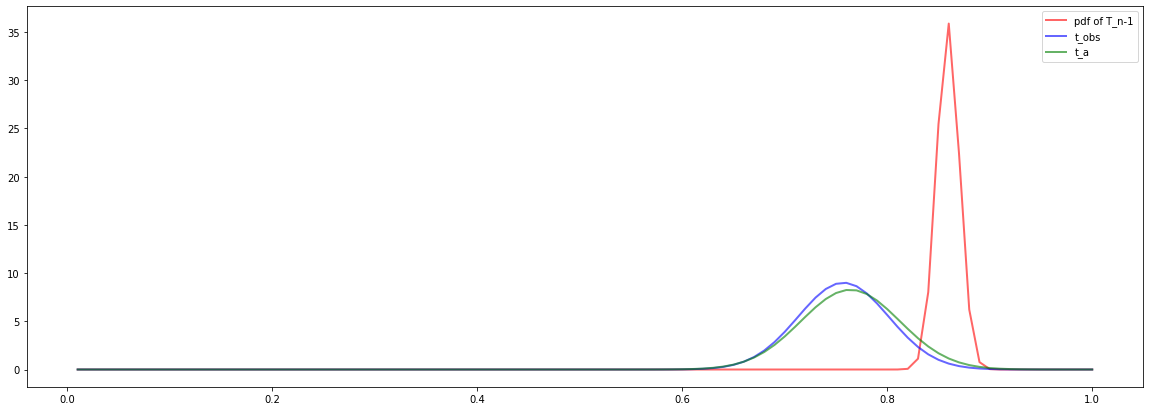

In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc



x = np.linspace(0.01,1, 100)

fig = plt.figure(figsize=(20,7))

plt.plot(x, sc.norm.pdf(x,loc=0.859214,scale=0.011093),
        'k-', lw=2, alpha=0.6, label='Training', color='r')

plt.plot(x, sc.norm.pdf(x,loc=0.757231,scale=0.044297),
'k-', lw=2, alpha=0.6, label='Validation', color='b')

plt.plot(x, sc.norm.pdf(x,loc=0.763987,scale=0.04823),
'k-', lw=2, alpha=0.6, label='BCR', color='g')

plt.legend(["pdf of T_n-1", "t_obs", "t_a"])